In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import plot_model

2024-03-26 15:40:53.502557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 15:40:53.502667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 15:40:53.666325: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Function to load data
def load_data(data_dir, target_names):
    img_arr = []
    img_label = []
    label_to_text = {}
    label = 0

    for dir_ in os.listdir(data_dir):
        if dir_ in target_names:
            for f in os.listdir(data_dir + dir_ + "/"):
                img = cv2.imread(data_dir + dir_ + "/" + f)
                img = cv2.resize(img, (128, 128))

                # Convert image to RGB format if it's grayscale
                if img.shape[-1] == 1:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                img_arr.append(img)
                img_label.append(label)
            print(f"loaded {dir_} images to numpy arrays...")
            label_to_text[label] = dir_
            label += 1

    img_arr = np.array(img_arr)
    img_label = np.array(img_label)
    img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

    return img_arr, img_label, label_to_text

In [ ]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load training data
data_dir_train = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/train/"
img_arr_train, img_label_train, label_to_text_train = load_data(data_dir_train, target_names)

# Load test data
data_dir_test = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/test/"
img_arr_test, img_label_test, label_to_text_test = load_data(data_dir_test, target_names)

INPUT_SHAPE = (128, 128, 3)
NUM_CLASSES = len(target_names)
BATCH_SIZE = 32
EPOCHS = 50

img_arr_train.shape, img_label_train.shape, label_to_text_train
img_arr_test.shape, img_label_test.shape, label_to_text_test

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((3068, 128, 128, 3),
 (3068, 7),
 {0: 'surprise',
  1: 'fear',
  2: 'angry',
  3: 'neutral',
  4: 'sad',
  5: 'disgust',
  6: 'happy'})

((3068, 128, 128, 3),
 (3068, 7),
 {0: 'surprise',
  1: 'fear',
  2: 'angry',
  3: 'neutral',
  4: 'sad',
  5: 'disgust',
  6: 'happy'})

In [ ]:
total_images_train = 0
for dir_ in os.listdir(data_dir_train):
    if dir_ in target_names:
        count = 0
        for f in os.listdir(data_dir_train + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of training images")
        total_images_train += count

print(f"\ntotal training images are {total_images_train}\n")

surprise has 1290 number of training images
fear has 281 number of training images
angry has 705 number of training images
neutral has 2524 number of training images
sad has 1982 number of training images
disgust has 717 number of training images
happy has 4772 number of training images

total training images are 12271



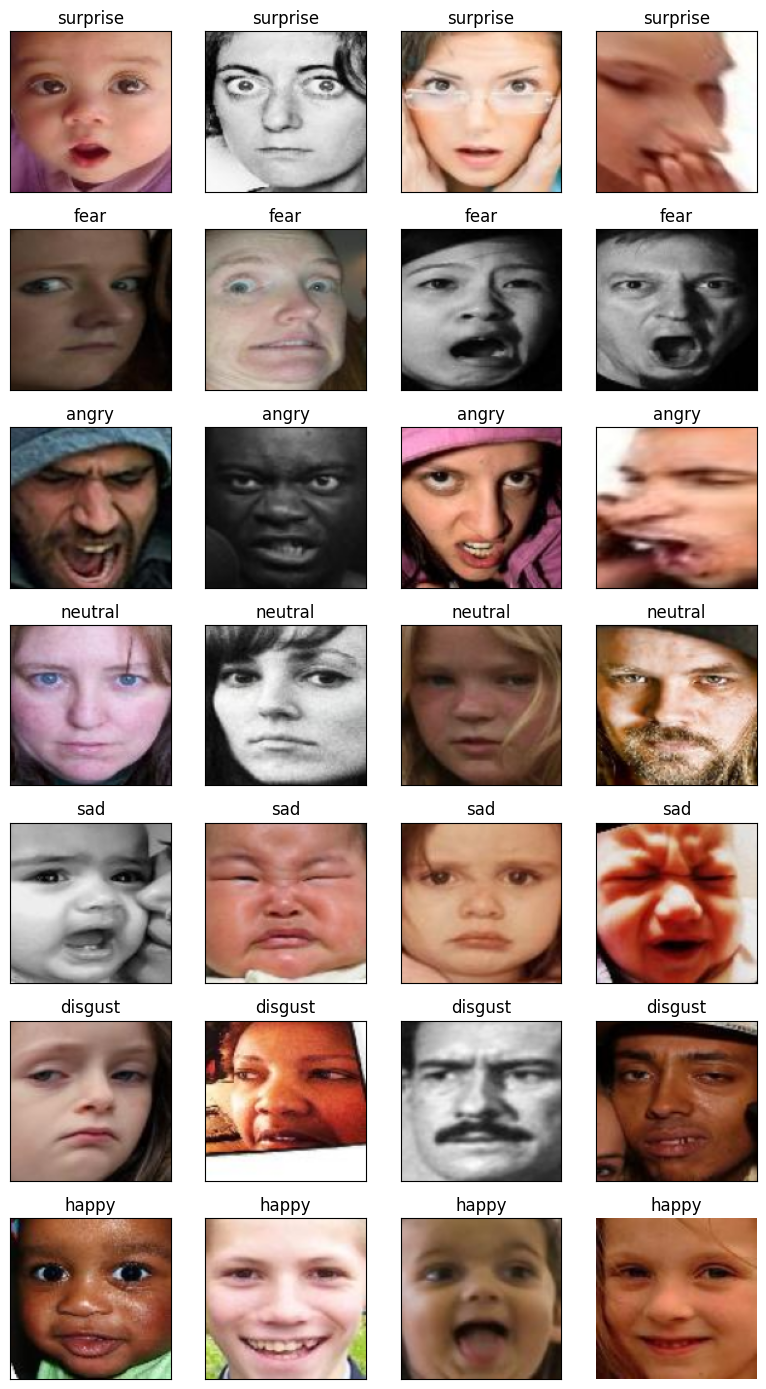

In [ ]:
num_emotions = len(target_names)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text_train:
    sample_indices = np.random.choice(np.where(img_label_train[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr_train[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img), plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text_train[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
    rescale=1./255  # Normalization
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Fit the data generator on training data
train_datagen.fit(img_arr_train)

# Fit the data generator on validation data
val_datagen.fit(img_arr_test)

In [ ]:
# Load the InceptionV3 model
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# Freeze layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Build custom model architecture on top of pre-trained model
inputs = Input(shape=INPUT_SHAPE)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,959 (84.17 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# Define callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
# Train the top layer
history_top_layer = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=BATCH_SIZE),
    validation_data=val_datagen.flow(img_arr_test, img_label_test, batch_size=BATCH_SIZE),
    steps_per_epoch=int(len(img_arr_train) / BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping],
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/383 ━━━━━━━━━━━━━━━━━━━━ 2:09:41 20s/step - accuracy: 0.1250 - loss: 4.1125

I0000 00:00:1711467797.084414      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711467797.137966      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


134/383 ━━━━━━━━━━━━━━━━━━━━ 44s 179ms/step - accuracy: 0.3844 - loss: 1.8532

W0000 00:00:1711467820.846875      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.4230 - loss: 1.6410

W0000 00:00:1711467855.149120      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711467865.969391      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 90s 181ms/step - accuracy: 0.4231 - loss: 1.6406 - val_accuracy: 0.5143 - val_loss: 1.3276 - learning_rate: 0.0010
Epoch 2/50
  1/383 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.4688 - loss: 1.4593

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4688 - loss: 1.4593 - val_accuracy: 0.5114 - val_loss: 1.3267 - learning_rate: 0.0010
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 118ms/step - accuracy: 0.5014 - loss: 1.3388 - val_accuracy: 0.5407 - val_loss: 1.2608 - learning_rate: 0.0010
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5312 - loss: 1.1467 - val_accuracy: 0.5434 - val_loss: 1.2607 - learning_rate: 0.0010
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.5296 - loss: 1.2796 - val_accuracy: 0.5303 - val_loss: 1.2617 - learning_rate: 0.0010
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4062 - loss: 1.3816 - val_accuracy: 0.5238 - val_loss: 1.2765 - learning_rate: 0.0010
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 45s 116ms/step - accuracy: 0.5276 - loss: 1.2593 - val_accuracy: 0.5456 - val_loss: 1.2373 - learning_rate: 0.0010
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6562 - loss: 0.9680 - va

In [ ]:
# Create history dataframe for the top layer training
history_top_layer_df = pd.DataFrame(history_top_layer.history)
history_top_layer_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.459188,1.475853,0.514342,1.327612,0.001000
1,0.468750,1.459331,0.511408,1.326684,0.001000
2,0.511480,1.322891,0.540743,1.260832,0.001000
3,0.531250,1.146659,0.543351,1.260694,0.001000
4,0.520876,1.288041,0.530313,1.261749,0.001000
5,0.406250,1.381628,0.523794,1.276515,0.001000
6,0.533785,1.256233,0.545632,1.237321,0.001000
7,0.656250,0.967981,0.546610,1.239813,0.001000
8,0.539341,1.237242,0.545632,1.268352,0.001000
9,0.531250,1.235111,0.550847,1.266793,0.001000


In [ ]:
# Fine-tuning the entire model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model after fine-tuning
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,065,959 (84.17 MB)

 Trainable params: 22,031,527 (84.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
# Train the entire model end-to-end with a low learning rate
history_fine_tuning = model.fit(
    train_datagen.flow(img_arr_train, img_label_train, batch_size=BATCH_SIZE),
    validation_data=val_datagen.flow(img_arr_test, img_label_test, batch_size=BATCH_SIZE),
    steps_per_epoch=int(len(img_arr_train) / BATCH_SIZE),
    epochs = EPOCHS,
    callbacks = [lr_scheduler, early_stopping],
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/383 ━━━━━━━━━━━━━━━━━━━━ 8:11:47 77s/step - accuracy: 0.4375 - loss: 1.7077

W0000 00:00:1711469100.924063      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


368/383 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.3592 - loss: 1.6557

W0000 00:00:1711469183.353292      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.3603 - loss: 1.6536

W0000 00:00:1711469190.328329      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 172s 248ms/step - accuracy: 0.3604 - loss: 1.6535 - val_accuracy: 0.4694 - val_loss: 1.4590 - learning_rate: 1.0000e-05
Epoch 2/50


W0000 00:00:1711469195.509211      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/383 ━━━━━━━━━━━━━━━━━━━━ 50s 133ms/step - accuracy: 0.4688 - loss: 1.4976

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4688 - loss: 1.4976 - val_accuracy: 0.4690 - val_loss: 1.4594 - learning_rate: 1.0000e-05
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.4542 - loss: 1.4685 - val_accuracy: 0.5114 - val_loss: 1.3608 - learning_rate: 1.0000e-05
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5625 - loss: 1.2686 - val_accuracy: 0.5108 - val_loss: 1.3603 - learning_rate: 1.0000e-05
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 122ms/step - accuracy: 0.5109 - loss: 1.3362 - val_accuracy: 0.5583 - val_loss: 1.2314 - learning_rate: 1.0000e-05
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5312 - loss: 1.1692 - val_accuracy: 0.5583 - val_loss: 1.2307 - learning_rate: 1.0000e-05
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 123ms/step - accuracy: 0.5616 - loss: 1.2124 - val_accuracy: 0.5955 - val_loss: 1.1462 - learning_rate: 1.0000e-05
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.

In [ ]:
# Create history dataframe for fine-tuning
history_fine_tuning_df = pd.DataFrame(history_fine_tuning.history)
history_fine_tuning_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.387940,1.602078,0.469361,1.459033,0.000010
1,0.468750,1.497573,0.469035,1.459447,0.000010
2,0.477408,1.417547,0.511408,1.360760,0.000010
3,0.562500,1.268575,0.510756,1.360276,0.000010
4,0.525860,1.299943,0.558344,1.231411,0.000010
5,0.531250,1.169164,0.558344,1.230708,0.000010
6,0.564997,1.195546,0.595502,1.146193,0.000010
7,0.718750,0.813998,0.594850,1.145881,0.000010
8,0.595964,1.119006,0.621904,1.073509,0.000010
9,0.593750,1.092460,0.622229,1.073812,0.000010


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

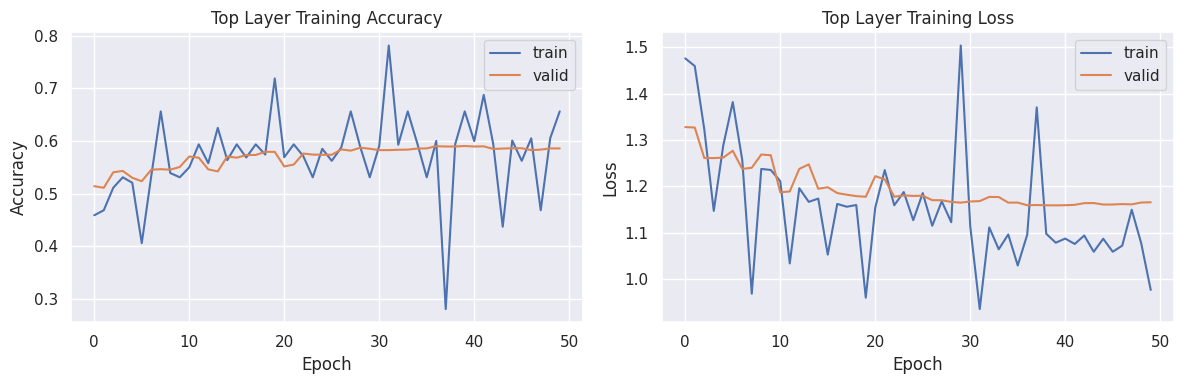

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

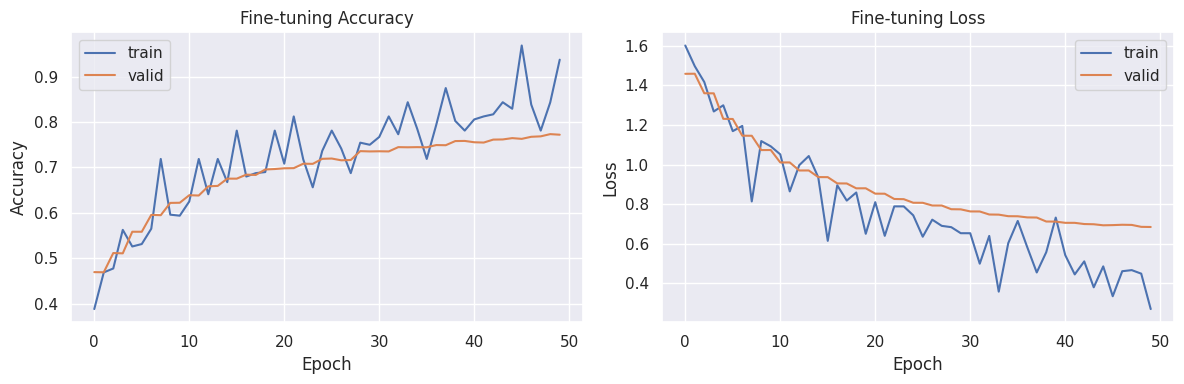

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize training history for the top layer training
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['accuracy'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_accuracy'], label='valid')
plt.title('Top Layer Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['loss'], label='train')
sns.lineplot(x=history_top_layer_df.index, y=history_top_layer_df['val_loss'], label='valid')
plt.title('Top Layer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

# Visualize training history for fine-tuning
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['accuracy'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_accuracy'], label='valid')
plt.title('Fine-tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['loss'], label='train')
sns.lineplot(x=history_fine_tuning_df.index, y=history_fine_tuning_df['val_loss'], label='valid')
plt.title('Fine-tuning Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()

plt.show()

384/384 - 43s - 111ms/step - accuracy: 0.8922 - loss: 0.3187

train Accuracy: 0.892184853553772
96/96 - 2s - 24ms/step - accuracy: 0.7735 - loss: 0.6854

Test Accuracy: 0.7734680771827698
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step

Classification Report:
               precision    recall  f1-score   support

       angry       0.76      0.75      0.76       329
     disgust       0.64      0.50      0.56        74
        fear       0.70      0.66      0.68       162
       happy       0.71      0.76      0.73       680
     neutral       0.72      0.72      0.72       478
         sad       0.45      0.25      0.32       160
    surprise       0.87      0.91      0.89      1185

    accuracy                           0.77      3068
   macro avg       0.69      0.65      0.67      3068
weighted avg       0.76      0.77      0.77      3068



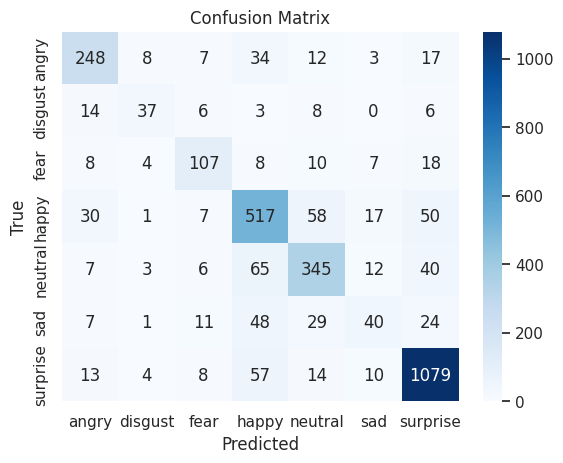

In [ ]:
# Evaluate the model
train_results = model.evaluate(train_datagen.flow(img_arr_train, img_label_train, batch_size=BATCH_SIZE), verbose=2)
train_loss = train_results[0]
train_acc = train_results[1]
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_results = model.evaluate(val_datagen.flow(img_arr_test, img_label_test, batch_size=BATCH_SIZE), verbose=2)
test_loss = test_results[0]
test_acc = test_results[1]
print(f"\nTest Accuracy: {test_acc}")

# Make predictions
predictions = model.predict(val_datagen.flow(img_arr_test, batch_size=BATCH_SIZE, shuffle=False))
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(img_label_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

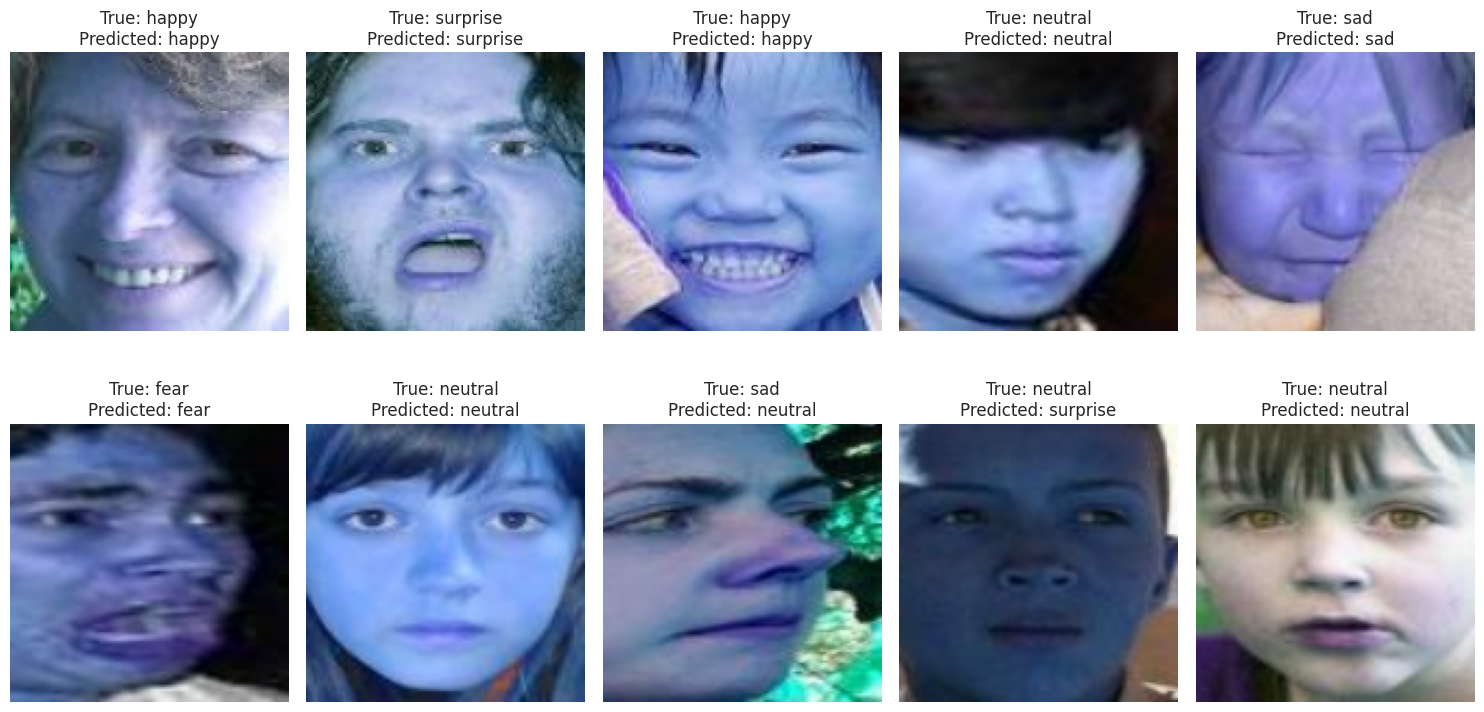

In [ ]:
import random

# Visualize some predictions
num_images_to_visualize = 10
random_indices = np.random.choice(len(img_arr_test), size=num_images_to_visualize, replace=False)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img_arr_test[idx])
    plt.title(f"True: {label_to_text_test[true_labels[idx]]}\nPredicted: {label_to_text_test[predicted_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()